In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN, AgglomerativeClustering

c:\Users\khans\miniconda3\envs\managedata\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('book.tsv', sep='\t', header=None)
# df = pd.read_csv('book-snippet.tsv', sep='\t', header=None)
# df = df.head(5000)
df = df.dropna(subset=[df.columns[3]])

authors = df.iloc[:, 3]
# authors = source[145:165]
# authors = pd.concat([authors, source[420:440]]) 
# authors = source[:5000]
# authors = source

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# author_embeddings = [model.encode(author) for author in authors]
author_embeddings = np.load('author_embeddings.npy')

In [3]:
np.save('author_embeddings.npy', author_embeddings)

In [4]:
cosine_similarities = cosine_similarity(author_embeddings)
print(cosine_similarities.shape)

(33246, 33246)


In [5]:
# complement = np.ones(cosine_similarities.shape)
# complement -= cosine_similarities
# complement = np.maximum(complement, 0)
# print(cosine_similarities)
# print(complement)
# print(authors)

In [6]:
# clustering = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=0.3).fit(complement)

# # Get cluster labels
# cluster_labels = clustering.labels_
# print(f'Num clusters: {clustering.n_clusters_}')

# # Group authors based on cluster labels
# clustered_authors = {}
# for i, label in enumerate(cluster_labels):
#     if label not in clustered_authors:
#         clustered_authors[label] = []
#     clustered_authors[label].append(authors.iloc[i])

# # Print authors in each cluster
# for cluster, authors_names in clustered_authors.items():
#     print(f'Cluster {cluster}:')
#     print(authors_names)

In [7]:
# dclustering = DBSCAN(min_samples=1).fit(complement)
# cosine_similarities = np.maximum(complement, 0)
# dbscan = DBSCAN(eps=0.5, min_samples=2, metric='precomputed')
# labels = dbscan.fit_predict(cosine_similarities)

# # Print the cluster labels
# print("Cluster labels:", labels[:900])


In [8]:
# Brute force approach: Group together all indices where cosine similarity is > 0.8
# groups = {} 
# for i in range(len(cosine_similarities)):
#     groups[i] = []

# for i in range(len(cosine_similarities)):
#     for j in range(i+1, len(cosine_similarities[0])):
#         if cosine_similarities[i][j] > 0.8:
#             groups[i].append(j)
#             # groups[j].append(i)

row_indices, col_indices = np.where(cosine_similarities > 0.8)

groups = {}

# Iterate over unique row indices
for i in np.unique(row_indices):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols = col_indices[row_indices == i]
    
    # Store relevant column indices in groups
    groups[i] = relevant_cols.tolist()

In [9]:
graph = groups.copy()
clusters = []
visited = set()

def dfs(v, curr_cluster):
    visited.add(v)
    curr_cluster.append(v)
    for w in graph[v]:
        if w not in visited:
            dfs(w, curr_cluster)

for node in graph:
    if node not in visited:
        cluster = []
        dfs(node, cluster)
        clusters.append(cluster)

# print(clusters)

In [10]:
with open('clusters.txt', 'w') as f:
    for clus in clusters:
        f.write('[')
        for idx in clus:
            f.write(f'{authors.iloc[idx]}; ')
        f.write(']\n\n')

In [11]:
print(len(clusters))
unique_values_count = df.iloc[:, 0].nunique()
print("Number of unique values in 'isbn' column:", unique_values_count)

1877
Number of unique values in 'isbn' column: 876


In [12]:
#### Testing phase ####
# For now, set the golden entity to be the string with the longest length in the cluster
df_cleaned = df.copy(deep=True)

longest_authors = []

for cluster in clusters:
    cluster_strings = authors.iloc[cluster]
    longest_author = max(cluster_strings, key=len)
    longest_authors.append(longest_author)
    # print(f'{cluster_strings}\nLongest author: {longest_author}\n#######################\n')
    for clust_idx in cluster:
        df_cleaned.iloc[clust_idx, 3] = longest_author

# Output DataFrame to a TSV file
output_file = 'cleaned-book.tsv'
df_cleaned.to_csv(output_file, sep='\t', index=False)

In [13]:
#### For each ISBN, count the number of unique authors ####
result = df_cleaned.groupby(1)[3].nunique()
print(result)
result.to_csv('result.tsv', sep='\t', index=True)


1
0023606924       4
0080439977       5
0120121484       3
0120121506       3
0120121514       3
                ..
9780078204616    2
9780078216770    2
9780078227813    2
9780079136787    5
9780335216369    2
Name: 3, Length: 1263, dtype: int64


10


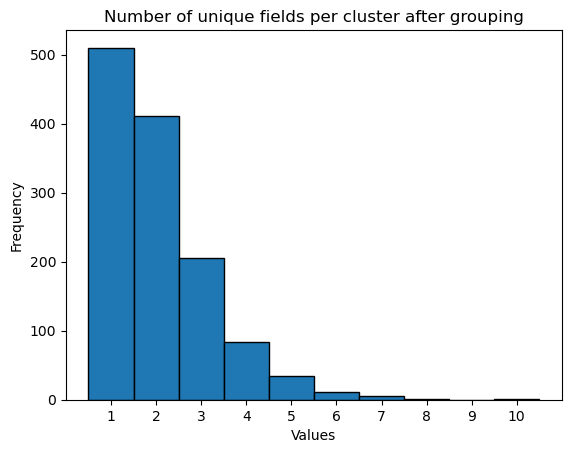

In [19]:
import matplotlib.pyplot as plt
# print(result.iloc[1])
print(result.max())
n_bins = result.max()
n, bins, patches = plt.hist(result, bins=n_bins, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

29


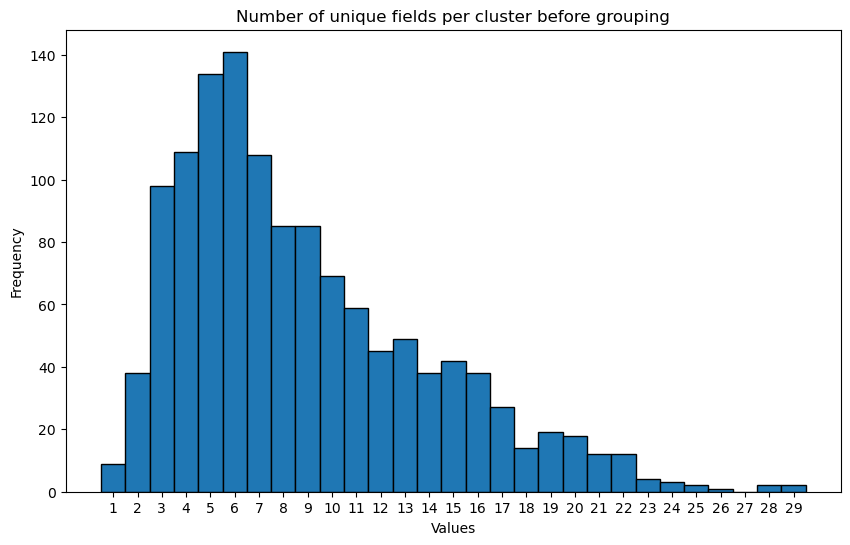

In [18]:
old_df = df.groupby(1)[3].nunique()

print(old_df.max())
n_bins = old_df.max()
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(old_df, bins=n_bins,edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster before grouping')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

Authors filtered length: 30115
1
0023606924       3
0080439977       2
0120121484       2
0120121506       3
0120121514       2
                ..
9780078204616    2
9780078216770    1
9780078227813    2
9780079136787    2
9780335216369    2
Name: 3, Length: 1261, dtype: int64
6


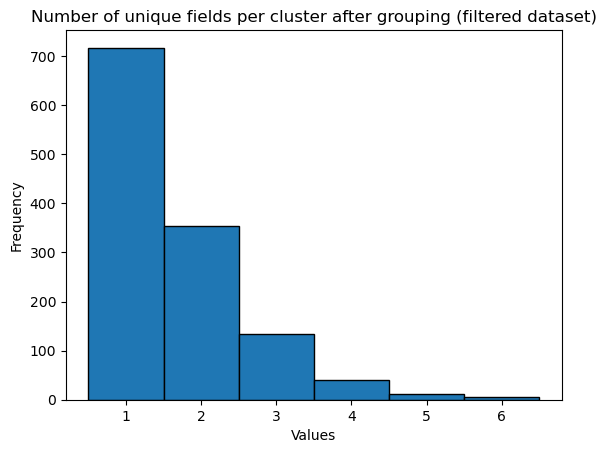

In [35]:
### Exploration: How well does this work in cases where there are
### no fields where the author is just one name, or several authors
### are abbreviated to et al?
import re

def remove_substrings(cell):
    if isinstance(cell, str):
        return re.sub(r'\b(author|by|edited|editor)\b', '', cell, flags=re.IGNORECASE)
    else:
        return cell

#### Drop the relevant rows and recreate embeddings + cosine similarity matrix
df = df.reset_index(drop=True)
df_filtered = df[~((df.iloc[:, 3].str.split().str.len() == 1) | (df.iloc[:, 3].str.contains('et al|et. al')))]
df_filtered.iloc[:,3] = df_filtered.iloc[:,3].apply(remove_substrings)
authors = df_filtered.iloc[:, 3]

print(f'Authors filtered length: {len(authors)}')

# author_embeddings_filtered = [model.encode(author) for author in authors]
author_embeddings_filtered = np.load('author_embeddings_filtered.npy')
np.save('author_embeddings_filtered.npy', author_embeddings_filtered)

cosine_similarities_filtered = cosine_similarity(author_embeddings_filtered)

#### Cluster the similar authors
row_indices_f, col_indices_f = np.where(cosine_similarities_filtered > 0.8)
groups_f = {}
# Iterate over unique row indices
for i in np.unique(row_indices_f):
    # Find the column indices where cosine_similarities > 0.8 for this row
    relevant_cols_f = col_indices_f[row_indices_f == i]
    
    # Store relevant column indices in groups
    groups_f[i] = relevant_cols_f.tolist()

graph_f = groups_f.copy()
clusters_f = []
visited_f = set()

def dfs_f(v, curr_cluster):
    visited_f.add(v)
    curr_cluster.append(v)
    for w in graph_f[v]:
        if w not in visited_f:
            dfs_f(w, curr_cluster)

for node_f in graph_f:
    if node_f not in visited_f:
        cluster_f = []
        dfs_f(node_f, cluster_f)
        clusters_f.append(cluster_f)


#### Testing phase ####
df_cleaned_f = df_filtered.copy(deep=True)

longest_authors_f = []

for cluster_f in clusters_f:
    cluster_strings_f = authors.iloc[cluster_f]
    longest_author_f = max(cluster_strings_f, key=len)
    longest_authors_f.append(longest_author_f)
    # print(f'{cluster_strings}\nLongest author: {longest_author}\n#######################\n')
    for clust_idx in cluster_f:
        df_cleaned_f.iloc[clust_idx, 3] = longest_author_f

# Output DataFrame to a TSV file
output_file_f = 'cleaned-book-filtered.tsv'
df_cleaned_f.to_csv(output_file_f, sep='\t', index=False)

#### For each ISBN, count the number of unique authors ####
result_f = df_cleaned_f.groupby(1)[3].nunique()
print(result_f)
result_f.to_csv('result-filtered.tsv', sep='\t', index=True)

print(result_f.max())
n_bins = result_f.max()
n, bins, patches = plt.hist(result_f, bins=n_bins, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Number of unique fields per cluster after grouping (filtered dataset)')
# Calculate centers of each bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
# Set x-axis ticks to the calculated bin centers
plt.xticks(bin_centers, range(1, n_bins+1))
plt.show()

In [17]:
print(len(clusters_f))
print(len(clusters))

1640
1877


In [26]:
print(result.mean())
print(result.median())
print(result.std())
print(result.quantile(0.25))
print(result.quantile(0.75))

2.0427553444180524
2.0
1.1895248060401993
1.0
3.0


In [25]:
print(old_df.mean())
print(old_df.median())
print(old_df.std())
print(old_df.quantile(0.25))
print(old_df.quantile(0.75))

8.80443388756928
7.0
5.103422857019719
5.0
12.0


In [36]:
print(result_f.mean())
print(result_f.median())
print(result_f.std())
print(result_f.quantile(0.25))
print(result_f.quantile(0.75))

1.6447264076130055
1.0
0.9062557851421786
1.0
2.0
